In [1]:
!pip install -q evaluate
!pip install -q bert-score
!pip install -q rouge-score
!pip install -q sacrebleu

**NOTE**

- this notebook rquires A100 GPU to run without errors
- the training loop takes around 54GB GPU RAM

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import BlipProcessor, BlipForConditionalGeneration, AutoTokenizer, AutoModel
from PIL import Image
import numpy as np
from tqdm import tqdm
import evaluate
from sacrebleu import corpus_bleu
from rouge_score import rouge_scorer
import torch.optim as optim


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
EPOCHS = 3

Using device: cuda


### Dataset Preprocessing

In [3]:
dataset = load_dataset("Fakhraddin/NLMCXR")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

class MedicalCaptionDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        text = item["text"]

        #blip takes pixel_values (image) and input_ids (text labels)
        encoding = self.processor(
            images=image,
            text=text,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # removing batch dimension added by the data processor
        encoding = {k: v.squeeze() for k, v in encoding.items()}

        # copying input_ids to labels
        encoding["labels"] = encoding["input_ids"].clone()
        return encoding, text

# creating train and val datasets
train_dataset = MedicalCaptionDataset(dataset["train"], processor)
val_dataset = MedicalCaptionDataset(dataset["validation"], processor)

# creating dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=4
    )

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Finetuning Loop

In [4]:
# import gc
# # Delete old models if variables exist
# if 'model' in globals(): del model
# if 'processor' in globals(): del processor
# gc.collect()
# torch.cuda.empty_cache()

In [5]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

model.train()

print(f"Starting fine-tuning for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch, _ in progress_bar:
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        # blip calculates loss internally given labels
        labels = batch.pop("labels").to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

print("Fine-tuning complete.")
model.save_pretrained("./blip-finetuned-nlmcxr")
processor.save_pretrained("./blip-finetuned-nlmcxr")

Starting fine-tuning for 3 epochs...


Epoch 1/3: 100%|██████████| 186/186 [05:44<00:00,  1.85s/it, loss=0.228]


Epoch 1 Average Loss: 2.4752


Epoch 2/3: 100%|██████████| 186/186 [05:44<00:00,  1.85s/it, loss=0.196]


Epoch 2 Average Loss: 0.2396


Epoch 3/3: 100%|██████████| 186/186 [05:43<00:00,  1.85s/it, loss=0.131]


Epoch 3 Average Loss: 0.1837
Fine-tuning complete.


[]

### Batched Generation

In [6]:
model.eval()

def collate_fn_eval(batch):
    # This collate separates the raw text from the tensor data for generation
    # 'batch' is a list of tuples: (encoding_dict, raw_text_str) from our Dataset class
    images = []
    texts = []
    for encoding, text in batch:
        # reconstructing the pixel_values for the batch
        # encoding['pixel_values'] is a tensor
        images.append(encoding['pixel_values'])
        texts.append(text)

    pixel_values = torch.stack(images)
    return pixel_values, texts

eval_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn_eval)

preds, refs = [], []
print("Generating captions for evaluation...")

with torch.no_grad():
    for pixel_values, batch_texts in tqdm(eval_loader, desc="Generating"):
        pixel_values = pixel_values.to(device)

        output_ids = model.generate(pixel_values=pixel_values, max_new_tokens=50)

        batch_preds = processor.batch_decode(output_ids, skip_special_tokens=True)

        preds.extend(batch_preds)
        refs.extend(batch_texts)

print(f"Generated {len(preds)} predictions.")

Generating captions for evaluation...


Generating: 100%|██████████| 48/48 [01:16<00:00,  1.59s/it]

Generated 1505 predictions.


### Calculating Metrics

In [7]:
print("Computing Evaluation Metrics...")

# COsine Similairty
print("Computing Cosine Similarity...")
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

def get_embeddings_batched(text_list, batch_size=128):
    all_embs = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i : i + batch_size]
        inputs = bert_tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embs = outputs.last_hidden_state[:, 0, :].cpu()
        all_embs.append(embs)
    return torch.cat(all_embs, dim=0)

pred_embs = get_embeddings_batched(preds)
ref_embs = get_embeddings_batched(refs)
cosine_sims = torch.nn.functional.cosine_similarity(pred_embs, ref_embs, dim=1)
avg_cosine = cosine_sims.mean().item()

# BLEU
print("Computing BLEU...")
avg_bleu = corpus_bleu(preds, [refs]).score

# ROUGE
print("Computing ROUGE...")
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1s, rouge2s, rougeLs = [], [], []
for r, p in zip(refs, preds):
    s = scorer.score(r, p)
    rouge1s.append(s['rouge1'].fmeasure)
    rouge2s.append(s['rouge2'].fmeasure)
    rougeLs.append(s['rougeL'].fmeasure)
avg_rouge1 = np.mean(rouge1s)
avg_rouge2 = np.mean(rouge2s)
avg_rougeL = np.mean(rougeLs)

# BERTSCore
print("Computing BERTScore...")
bertscore_metric = evaluate.load("bertscore")
results = bertscore_metric.compute(predictions=preds, references=refs, model_type="bert-base-uncased", batch_size=64, device=device)
avg_bertscore = np.mean(results["f1"])

print("\n" + "="*40)
print(f"  Fine-Tuned BLIP Evaluation Report")
print("="*40)
print(f"Avg. Cosine Similarity: {avg_cosine:.4f}")
print(f"Avg. BLEU:              {avg_bleu:.4f}")
print(f"Avg. ROUGE-1:           {avg_rouge1:.4f}")
print(f"Avg. ROUGE-2:           {avg_rouge2:.4f}")
print(f"Avg. ROUGE-L:           {avg_rougeL:.4f}")
print(f"Avg. BERTScore (F1):    {avg_bertscore:.4f}")
print("="*40)

Computing Evaluation Metrics...
Computing Cosine Similarity...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Computing BLEU...
Computing ROUGE...
Computing BERTScore...



  Fine-Tuned BLIP Evaluation Report
Avg. Cosine Similarity: 0.8932
Avg. BLEU:              5.4903
Avg. ROUGE-1:           0.3647
Avg. ROUGE-2:           0.1478
Avg. ROUGE-L:           0.2780
Avg. BERTScore (F1):    0.6856


### Save the model to HuggingFace

In [8]:
repo_id = "abhay2812/blipfinetuned_nlmcxr"

model.push_to_hub(repo_id)
processor.push_to_hub(repo_id)


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...zc7l3j1/model.safetensors:   0%|          |  573kB /  896MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/abhay2812/blipfinetuned_nlmcxr/commit/6eb6c8d982c1efaad0fdb93369a99f1889f02edb', commit_message='Upload processor', commit_description='', oid='6eb6c8d982c1efaad0fdb93369a99f1889f02edb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/abhay2812/blipfinetuned_nlmcxr', endpoint='https://huggingface.co', repo_type='model', repo_id='abhay2812/blipfinetuned_nlmcxr'), pr_revision=None, pr_num=None)

### Drawing Boxplots

/tmp/ipython-input-1188450322.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_melted, x="Metric", y="Score", palette="viridis", showmeans=True)


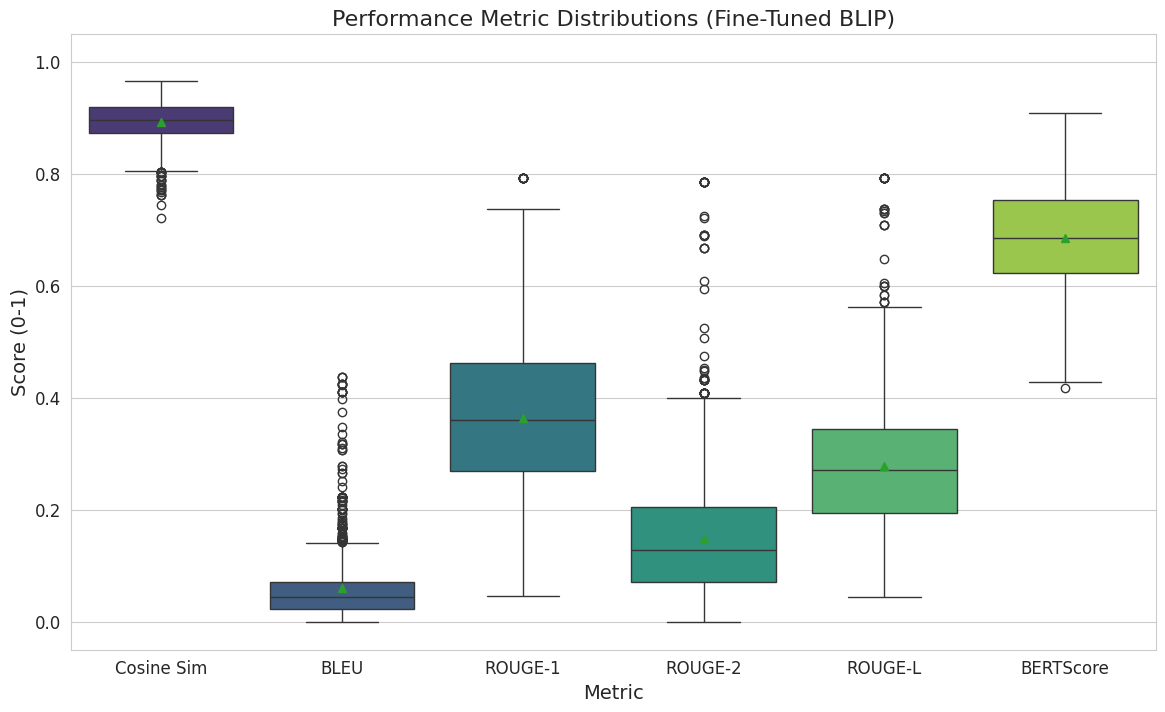


===== Statistical Summary =====
              mean     std     min     50%     max
Cosine Sim  0.8932  0.0355  0.7212  0.8960  0.9658
BLEU        0.0602  0.0618  0.0001  0.0450  0.4370
ROUGE-1     0.3647  0.1340  0.0465  0.3600  0.7931
ROUGE-2     0.1478  0.1180  0.0000  0.1277  0.7857
ROUGE-L     0.2780  0.1236  0.0444  0.2712  0.7931
BERTScore   0.6856  0.0822  0.4171  0.6852  0.9079


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sacrebleu import sentence_bleu

cosine_scores = cosine_sims.cpu().numpy()
bert_scores = results["f1"]

# Calculate Sentence-Level BLEU for distribution
bleu_scores = []
for p, r in zip(preds, refs):
    #normalize to 0-1 to match other metrics
    score = sentence_bleu(p, [r]).score
    bleu_scores.append(score / 100.0)

# creating  a DataFrame combining all metrics
df_metrics = pd.DataFrame({
    "Cosine Sim": cosine_scores,
    "BLEU": bleu_scores,
    "ROUGE-1": rouge1s,
    "ROUGE-2": rouge2s,
    "ROUGE-L": rougeLs,
    "BERTScore": bert_scores
})

# Plotting
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Transforming data to long format for Seaborn
df_melted = df_metrics.melt(var_name="Metric", value_name="Score")
ax = sns.boxplot(data=df_melted, x="Metric", y="Score", palette="viridis", showmeans=True)
plt.title("Performance Metric Distributions (Fine-Tuned BLIP)", fontsize=16)
plt.ylabel("Score (0-1)", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.ylim(-0.05, 1.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


print("\n===== Statistical Summary =====")
print(df_metrics.describe().T[['mean', 'std', 'min', '50%', 'max']].round(4))